# Global to local optimisation

A global optimisation solution can be fed into a local optimiser for further improvement. First, define a global solution (mfile) and plot it relative to the original local solution for the same IN.DAT.

In [1]:
import plot_solvers as ps
from pathlib import Path

# Reload Process each time (keep editable install up-to-date)
%load_ext autoreload
%aimport process, plot_solvers
%autoreload 1

/home/jon/code/notebooks/nlopt_process/plot_solvers.py:498: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(opt_params_labels)
/home/jon/code/notebooks/nlopt_process/plot_solvers.py:519: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(norm_objf_label)


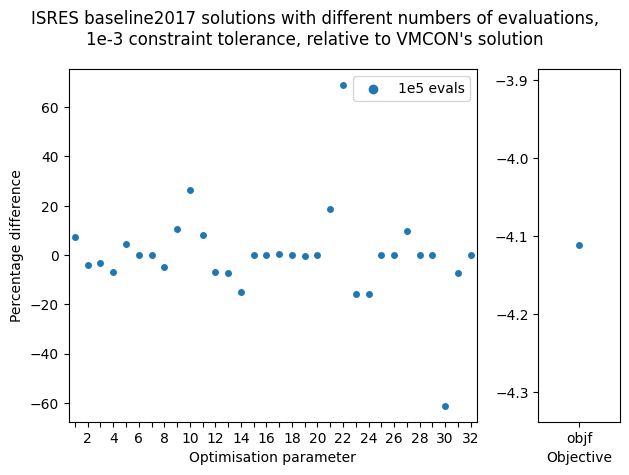

In [2]:
# Define data location
isres_run_dir = Path("/home/jon/data/process/baseline2017/numevals_isres_1e-3_tol")
vmcon_run_dir = Path("/home/jon/data/process/baseline2017/original")

mfile_name = "baseline_2017_MFILE.DAT"

# Mfiles and tags for each run to be plotted
runs_metadata = [
    ps.RunMetadata(vmcon_run_dir / "baseline2017_MFILE.DAT", "vmcon"),
    # ps.RunMetadata(isres_run_dir / "1e3" / mfile_name, "1e3 evals"),
    # ps.RunMetadata(isres_run_dir / "1e4" / mfile_name, "1e4 evals"),
    ps.RunMetadata(isres_run_dir / "1e5" / mfile_name, "1e5 evals"),
]

# Plot global solutions compared to VMCON
glob_soln_df = ps.global_comparison(
    runs_metadata,
    "vmcon",
    "ISRES baseline2017 solutions with different numbers of evaluations,\n1e-3 constraint tolerance, relative to VMCON's solution",
)


In [5]:
# Filter vars of interest
ps._filter_vars_of_interest(glob_soln_df)


,tag,norm_objf,xcm001,xcm002,xcm003,xcm004,xcm005,xcm006,xcm007,xcm008,...,xcm023,xcm024,xcm025,xcm026,xcm027,xcm028,xcm029,xcm030,xcm031,xcm032
0,vmcon,1.8922,0.93345,1.0429,1.0338,1.0719,0.95783,1.0,1.0,1.0499,...,1.1871,1.1871,1.0,1.0,0.91183,1.0,1.0,2.575,1.077,1.0
1,1e5 evals,1.8144,1.00000,1.0000,1.0000,1.0000,1.00000,1.0,1.0,1.0000,...,1.0000,1.0000,1.0,1.0,1.00000,1.0,1.0,1.000,1.000,1.0


This is a slightly wild solution (very low constraint tolerances), but nevertheless a good starting point. We want to use the output MFILE from the global solver (plotted above) as an IN.DAT for the local solver.

First, extract the solution (optimisation parameters) from the global optimisation.

In [6]:
from process.io.mfile import MFile
from process.io.in_dat import InDat

# Create Mfile object from global solution
mfile_path = isres_run_dir / "1e5" / mfile_name
mfile = MFile(mfile_path)

# Get number of optimisation parameters
n = int(mfile.data["nvar"].get_scan(-1))

# Get all n optimisation parameter names and values from "itvarxxx" number
opt_params = {}
for i in range(n):
    opt_param_no = f"itvar{i+1:03}"
    param_name = mfile.data[opt_param_no].var_description
    param_value = mfile.data[opt_param_no].get_scan(-1)
    opt_params[param_name] = param_value

# Print optimisation parameters at global solution
print(f"Global solution = {opt_params}")

Global solution = {'bt': 5.667, 'rmajor': 9.072, 'te': 13.07, 'beta': 0.03063, 'dene': 7.983e+19, 'fdene': 1.2, 'hfact': 1.1, 'tfcth': 1.05, 'fwalld': 0.1312, 'ohcth': 0.8181, 'q': 3.247, 'bore': 2.483, 'fbetatry': 0.4815, 'coheof': 13540000.0, 'fjohc': 0.25, 'fjohc0': 0.25, 'fcohbop': 0.9362, 'gapoh': 0.05, 'fvsbrnni': 0.4434, 'fstrcase': 1.0, 'fstrcond': 0.996, 'fiooic': 0.3978, 'fvdump': 0.6116, 'vdalw': 12.64, 'fjprot': 1.0, 'tdmptf': 30.0, 'thkcas': 0.4948, 'thwcndut': 0.004, 'gapds': 0.12, 'fimpvar': 0.0016, 'flhthresh': 1.271, 'fpsepbqar': 1.0}


Now overwrite the original input file with that global solution as the initial optimisation parameters.

In [7]:
# Now read in original IN.DAT
in_dat_dir = isres_run_dir / "1e5"
in_dat_name = "baseline_2017_IN.DAT"
in_dat_path = in_dat_dir / in_dat_name
in_dat = InDat(in_dat_path)

# Change to the new optimisation parameter values
for var_name, value in opt_params.items():
    in_dat.add_parameter(var_name, value)

# Write out new IN.DAT, with optimisation parameters set to global solution
new_in_dat_path = in_dat_dir / "local_IN.DAT"
in_dat.write_in_dat(new_in_dat_path)

## Running the local optimisation

The local optimisation can now be attempted from the global solution.

In [8]:
single_run = process.main.SingleRun(str(new_in_dat_path), solver="nlopt")

 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-529-g85cdde289 code contains untracked changes
    Branch : nlopt-test-2
   Git log : Simplify logging to process.log
 Date/time :  4 Apr 2023 17:23:05 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory : /home/jon/code/notebooks/nlopt_process
     Input : /home/jon/data/process/baseline2017/numevals_isres_1e-3_tol/1e5/local_IN.DAT
 Run title : Run Title (change this line using input variable 'runtitle')
  Run type : Reactor concept des

/home/jon/code/notebooks/nlopt_process/plot_solvers.py:498: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(opt_params_labels)
/home/jon/code/notebooks/nlopt_process/plot_solvers.py:519: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(norm_objf_label)


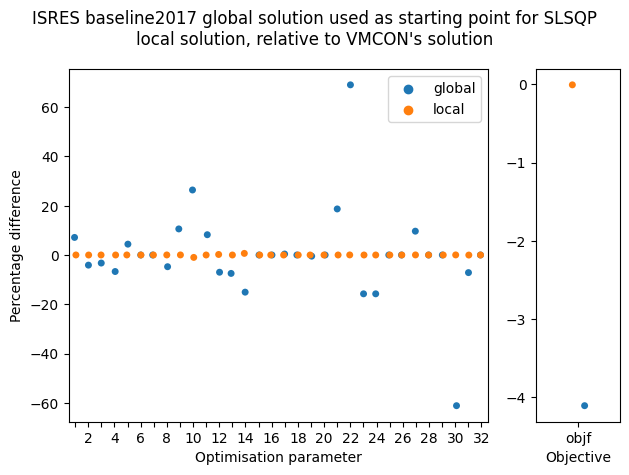

In [9]:
# Plot global and local solution on same plot

# Define data location
vmcon_run_dir = Path("/home/jon/data/process/baseline2017/original")
isres_run_dir = Path("/home/jon/data/process/baseline2017/numevals_isres_1e-3_tol")

mfile_name = "baseline_2017_MFILE.DAT"

# Mfiles and tags for each run to be plotted
runs_metadata = [
    ps.RunMetadata(vmcon_run_dir / "baseline2017_MFILE.DAT", "vmcon"),
    ps.RunMetadata(isres_run_dir / "1e5" / mfile_name, "global"),
    ps.RunMetadata(in_dat_dir / "local_MFILE.DAT", "local"),
]

# Plot global solutions compared to VMCON
glob_soln_df = ps.global_comparison(
    runs_metadata,
    "vmcon",
    "ISRES baseline2017 global solution used as starting point for SLSQP\nlocal solution, relative to VMCON's solution",
)

# TODO Could do with tidying up the local running, filenames etc.
